# Detectron2でインスタンスセグメンテーション

### GPUが使用できるか確認する

In [1]:
# check pytorch installation: 
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
# assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version


1.10.1 True


/home/hirahara/anaconda3/envs/d2/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### 必要なモジュールをインポートする

In [2]:
import sys
sys.path.append("./")
sys.path.append("./detectron2/")

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from pathlib import Path

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import matplotlib.pyplot as plt

### 適当な画像を読み込む

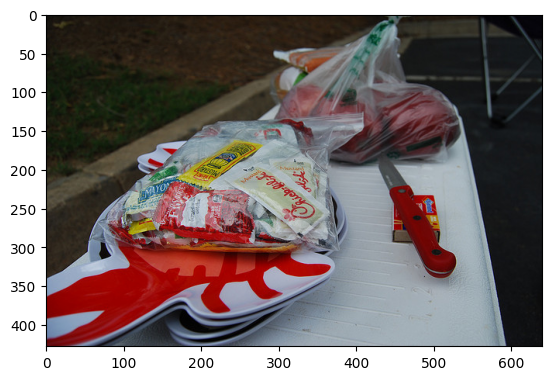

In [3]:
sample_img_path = random.choice(list(Path("./__datasets__/sample_coco_train2017/").glob("*.jpg")))
im = cv2.imread(str(sample_img_path))

plt.imshow(im[:, :, ::-1])
plt.show()

### Detectron2モデルを使って画像から物体を検出・セグメンテーションを行う

In [4]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

[05/26 11:35:54 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


/home/hirahara/anaconda3/envs/d2/lib/python3.9/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1639180487213/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


### Detectron2モデルで推論されたデータを描画する

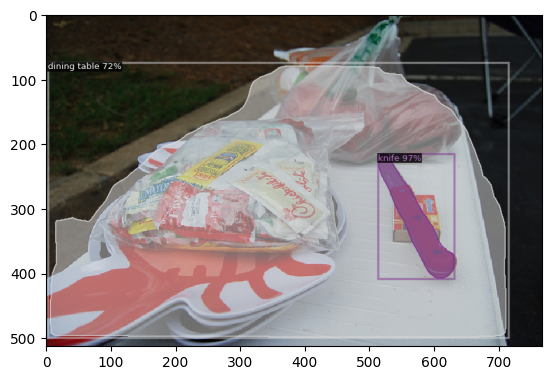

In [5]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.imshow(out.get_image()[:, :, ::-1])
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

### 様々な画像で体験

[05/26 11:40:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


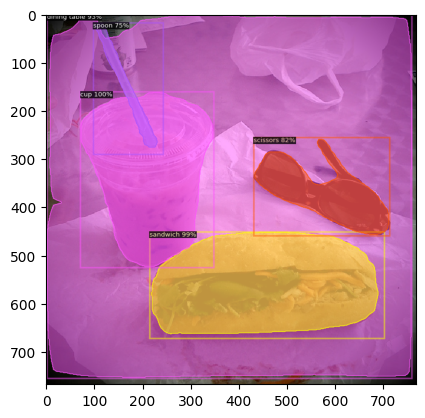

In [26]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

sample_img_path = random.choice(list(Path("./__datasets__/sample_coco_train2017/").glob("*.jpg")))
im = cv2.imread(str(sample_img_path))

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
# plt.imshow(out.get_image()[:, :, ::-1])
plt.imshow(cv2.cvtColor(out.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

### ぶどうの画像で検証

公開されているDetectron2のモデルは汎用性があり精度が高いが、特定の分野においては期待する検出結果が得られない。

[05/26 11:46:20 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl ...


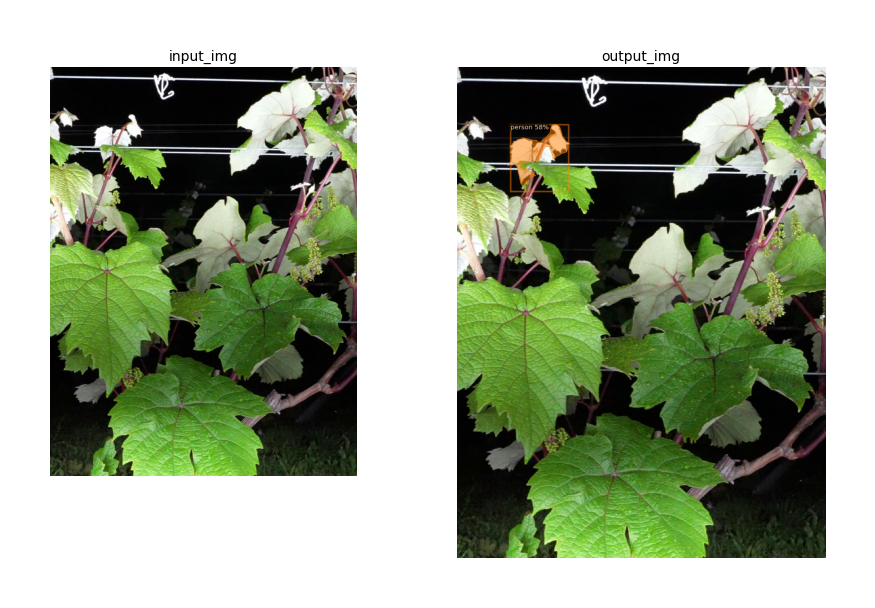

In [48]:
# 1枚の画像を表示する関数
def show_img(img, dpi=150, title=None):
    fig, ax = plt.subplots(nrows=1, ncols=1, dpi=dpi)
    ax.set_title( title, fontsize=16, color='black')
    ax.axis('off')
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return fig, ax

# 複数枚の画像を表示する関数
from mpl_toolkits.axes_grid1 import ImageGrid
def show_imgs(imgs_dict:dict, ncol=0, dpi=200, font_scale=0.7):
    font_size = int(plt.rcParams["font.size"]*font_scale)

    if ncol > 0:
        nrow = ((len(imgs_dict)-1)//ncol)+1
    else:
        nrow = 1
        ncol = len(imgs_dict)

    img_num = len(imgs_dict)
    fig = plt.figure(figsize=(float(img_num), float(img_num)), dpi=dpi)
    grid = ImageGrid(fig, 111, nrows_ncols=(nrow, ncol), axes_pad=0.2,)

    for i in range(nrow*ncol):
        grid[i].axis('off')
        if i < len(imgs_dict):
            img_key = list(imgs_dict.keys())[i]
            grid[i].imshow(cv2.cvtColor(imgs_dict[img_key], cv2.COLOR_BGR2RGB))
            grid[i].set_title(img_key, fontsize=font_size, color='black', pad=int(font_size/2))
    
    plt.show(); plt.close()
    return None


cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")

sample_img_path = random.choice(list(Path("./__datasets__/sentan_dataset/other/").glob("*.jpg")))
im = cv2.imread(str(sample_img_path))

predictor = DefaultPredictor(cfg)
outputs = predictor(im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


imgs = {}
imgs["input_img"] = im
imgs["output_img"] = out.get_image()[:, :, ::-1]
show_imgs(imgs, dpi=500, font_scale=0.2)

そのため、公開されている汎用的な学習済みモデルを独自のデータセットに適用させるために  
「ファインチューニング」と呼ばれる方法で独自データセットを追加学習させる。